<a href="https://colab.research.google.com/github/Milind712000/CS308-Sept-2020-Git-Lab-1/blob/master/metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
drive_prefix = '/content/drive'

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [ ]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools

In [ ]:
import matplotlib.patches as patches
from PIL import Image

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
class CDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, df, batch_size, input_size=(224, 224, 3), shuffle=True):
        
        self.df = df.copy()
        
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __get_input(self, in_obj, target_size):
    
        ind, file, x1, x2, y1, y2 = in_obj

        image = tf.keras.preprocessing.image.load_img(file)
        image_arr = tf.keras.preprocessing.image.img_to_array(image)

        image_arr = image_arr[y1:y2, x1:x2]
        image_arr = tf.image.resize(image_arr,(target_size[0], target_size[1])).numpy()

        return image_arr/255.
    
    def __get_output(self, label):
        return tf.keras.utils.to_categorical(label, num_classes=2)
    
    def __get_data(self, batches):
        # Generates data containing batch_size samples
        
        in_batch = batches[['file', 'bbox_left', 'bbox_right', 'bbox_top', 'bbox_bottom']]
        out_batch = batches['is_employee']

        X_batch = np.asarray([self.__get_input(obj1, self.input_size) for obj1 in in_batch.itertuples()])

        y_batch = self.__get_output(out_batch.to_numpy())

        return X_batch, y_batch
    
    def __getitem__(self, index):
        
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size


In [ ]:
def draw_boxes(row):
    # row = df.iloc[row_i]
    filepath = row['file']
    x1 = row['bbox_left']
    x2 = row['bbox_right']
    y1 = row['bbox_top']
    y2 = row['bbox_bottom']
    label = row['is_employee']

    img = np.array(Image.open(filepath), dtype=np.uint8)
    
    # Create figure and axes
    fig, ax = plt.subplots(1)
    
    # Display the image
    ax.imshow(img)

    if label:
      box_color = 'g'
    else:
      box_color = 'r'
    
    bbox_rect = patches.Rectangle((x1, y1), abs(x2-x1), abs(y2-y1), linewidth=1, edgecolor=box_color, facecolor="none")
    ax.add_patch(bbox_rect)
    
    plt.axis('off')
    plt.show()

In [ ]:
def person_id_pool_predict(df, model):
  grps = df.groupby('person_id')
  keys = grps.groups.keys()
  prediction_map = dict()
  for k in keys:
    cgrp = grps.get_group(k)
    data_gen = CDataGen(cgrp, 1, shuffle=False)
    y_pred = np.argmax(model.predict(data_gen), axis=-1)
    mode = np.argmax(np.sum(y_pred, axis=0))
    prediction_map[k] = mode
  
  jojo = prediction_map
  return df['person_id'].map(prediction_map).to_numpy().astype(int)

In [ ]:
classes_list = ['customer', 'employee']

In [ ]:
model_path = '/content/drive/MyDrive/AI/MYS19/models/12_model_v2.1.h5'

In [ ]:
test_df_path = '/content/drive/MyDrive/AI/MYS19/trace-3.csv'

In [ ]:
model = tf.keras.models.load_model(model_path)

In [ ]:
df =  pd.read_csv(test_df_path)
df.head()

,file,bbox_left,bbox_top,bbox_right,bbox_bottom,person_id,is_employee,camera
0,/content/drive/MyDrive/AI/MYS19/camera-3/frame...,1023,84,1072,212,d6eb4e23-3eba-4408-9d06-2f2af33eefe1,0,3
1,/content/drive/MyDrive/AI/MYS19/camera-3/frame...,982,74,1046,217,d6eb4e23-3eba-4408-9d06-2f2af33eefe1,0,3
2,/content/drive/MyDrive/AI/MYS19/camera-3/frame...,968,71,1011,210,d6eb4e23-3eba-4408-9d06-2f2af33eefe1,0,3
3,/content/drive/MyDrive/AI/MYS19/camera-3/frame...,917,74,981,210,d6eb4e23-3eba-4408-9d06-2f2af33eefe1,0,3
4,/content/drive/MyDrive/AI/MYS19/camera-3/frame...,901,69,938,208,d6eb4e23-3eba-4408-9d06-2f2af33eefe1,0,3


In [ ]:
test_gen = CDataGen(df, 1, shuffle=False)

In [ ]:
# loss, acc = model.evaluate(test_gen)
# print('loss : ', loss)
# print('accuracy : ', acc)

In [ ]:
y_pred = np.argmax(model.predict(test_gen), axis = -1)

In [ ]:
df['predicted'] = y_pred

In [ ]:
(y_pred == df['is_employee']).mean()

0.9288664525011473

In [ ]:
(df['predicted'] == df['is_employee']).mean()

0.9288664525011473

In [ ]:
pooldf = df.groupby('person_id').agg(
    true_class = pd.NamedAgg(column='is_employee', aggfunc=pd.Series.mode),
    pred_class = pd.NamedAgg(column='predicted', aggfunc=pd.Series.max),
    pred_mean = pd.NamedAgg(column='predicted', aggfunc=pd.Series.mean)
)

In [ ]:
pooldf['pred_class'] = pooldf.apply(lambda row : int(row['pred_mean'] > 0.1), axis = 1)

In [ ]:
(pooldf['pred_class'] == pooldf['true_class']).mean()

0.9294117647058824

In [ ]:
(df['predicted'] == df['is_employee']).mean()

0.9288664525011473

In [ ]:
cm = confusion_matrix(y_true=pooldf['true_class'], y_pred=pooldf['pred_class'])

Confusion matrix, without normalization
[[76  0]
 [ 6  3]]


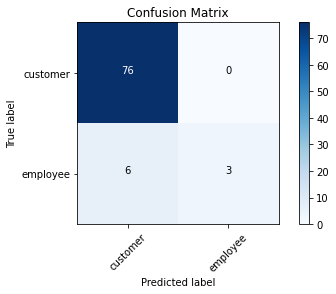

In [ ]:
plot_confusion_matrix(cm=cm, classes=classes_list, title='Confusion Matrix')

In [ ]:
true_cus = cm[0,0]
true_emp = cm[1,1]
fals_cus = cm[1,0]
fals_emp = cm[0,1]

In [ ]:
pres_emp = true_emp/(true_emp+fals_emp)
pres_cus = true_cus/(true_cus+fals_cus)
rcal_emp = true_emp / (true_emp+fals_cus)
rcal_cus = true_cus / (true_cus+fals_emp)

print('precision(employee)', round(pres_emp, 2))
print('precision(customer)', round(pres_cus, 2))
print('recall(employee)', round(rcal_emp, 2))
print('recall(customer)', round(rcal_cus, 2))

precision(employee) 1.0
precision(customer) 0.93
recall(employee) 0.33
recall(customer) 1.0


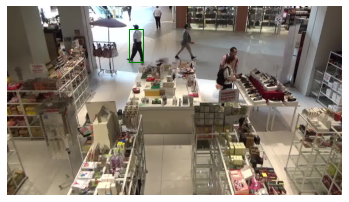

In [ ]:
row = df[y_pred != df['is_employee']].sample(n = 1).iloc[0]
draw_boxes(row)

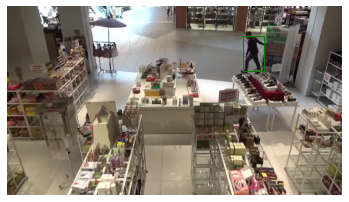

In [ ]:
# employees; false negative
row = df.sample(n = 1).iloc[0]
draw_boxes(row)